In [24]:
#Linear Regression in this context is just AR (autoregressive) model when no other predictors are given. 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts                              import TimeSeries
from darts.models                       import LinearRegressionModel,RegressionModel
from darts.dataprocessing.transformers  import Scaler

from sklearn.metrics import mean_squared_error

In [26]:
pdf = pd.read_csv("../../../data/daily/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  

pdf["y"] = (pdf["NE5_GWh"].values + pdf["NE7_GWh"].values)
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

#split data in train val and test
#2657/365/225 days in ratio 
split = len(pdf)-365-200
pdf_train, pdf_val, pdf_test = pdf.iloc[:split], pdf.iloc[split:split+365], pdf.iloc[split+365:]

ytrain = TimeSeries.from_dataframe(pdf_train)
yval   = TimeSeries.from_dataframe(pdf_val)
ytest  = TimeSeries.from_dataframe(pdf_test)
ytotal = TimeSeries.from_dataframe(pdf)


In [27]:
#encoders = {"datetime_attribute": {"future": ["dayofweek","month", "year"]},"transformer": Scaler()}
encoders = {"datetime_attribute": {"future": ["dayofweek"]},"transformer": Scaler()}
#the transformer in the dict above is for the encoder and not for the data. 

In [28]:
# from sklearn.linear_model import BayesianRidge
# from sklearn.ensemble import RandomForestRegressor 

model = RegressionModel(lags=[-7,-365],
                        lags_future_covariates=[0], 
                        add_encoders=encoders)

model.fit(series=ytrain)

RegressionModel(lags=[-7, -365], lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, add_encoders={'datetime_attribute': {'future': ['dayofweek']}, 'transformer': Scaler}, model=None, multi_models=True, use_static_covariates=True)

In [29]:
import inspect
# getmembers() returns all the
# members of an object
for i in inspect.getmembers(model)[100:]:
    if i[0].startswith('supports') == True:
        print(i[0],i[1])

    if i[0].startswith('uses') == True:
        print(i[0],i[1])

#stange why does the model support covariates

uses_static_covariates False


In [30]:
pred_test = model.predict(n=len(ytest), series=ytrain.append(yval)).pd_series()
pred_val  = model.predict(n=len(yval), series=ytrain).pd_series()

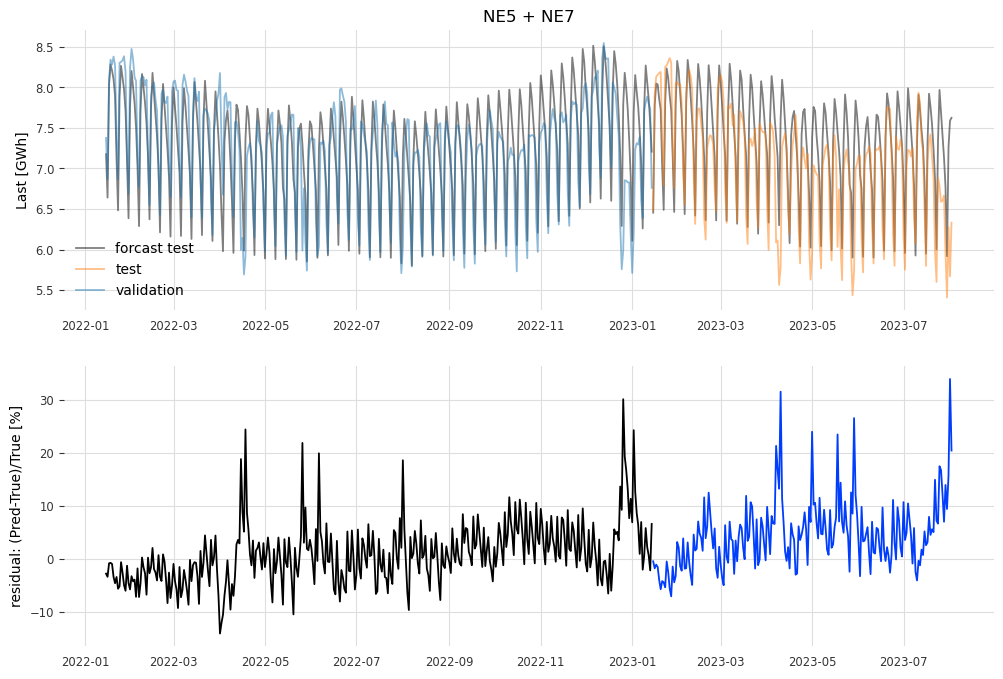

In [31]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(pred_test, color="black", label="forcast test", alpha=0.5)
axes[0].plot(pred_val, color="black", alpha=0.5)

# axes[0].plot(pdf_train[-2*365:], color="tab:blue", label="train")
axes[0].plot(pdf_test, color="tab:orange", label="test", alpha=0.5)
axes[0].plot(pdf_val, color="tab:blue", label="validation", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_val.index,  (pred_val.values  - pdf_val.y.values) /  (pdf_val.y.values)*100)
axes[1].plot(pdf_test.index, (pred_test.values - pdf_test.y.values) / (pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()

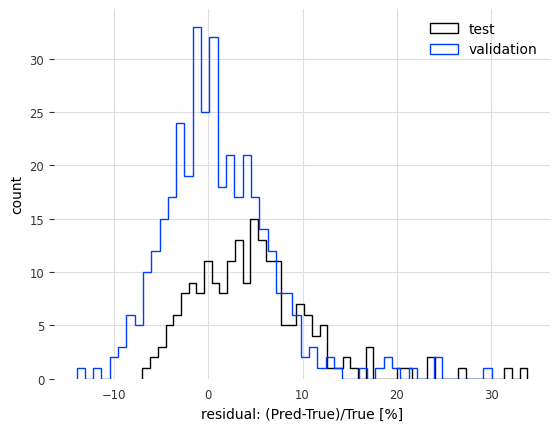

In [32]:
#histogramm of the residuals
plt.hist((pred_test.values - pdf_test.y.values) / (pdf_test.y.values)*100, bins=50, histtype='step', label="test")
plt.hist((pred_val.values -  pdf_val.y.values) /   (pdf_val.y.values)*100, bins=50, histtype='step', label="validation")
plt.legend()
plt.xlabel("residual: (Pred-True)/True [%]")
plt.ylabel("count")
plt.show()

In [33]:
rmse = mean_squared_error(pdf_val.y.values, pred_val.values, squared=False)
print(f"RMSE on validation set: {rmse:.3f}")

rmse = mean_squared_error(pdf_test.y.values,pred_test.values, squared=False)
print(f"RMSE on test set: {rmse:.3f}")

RMSE on validation set: 0.403
RMSE on test set: 0.513
